## ¿Las escuelas realmente cumplen con las normas sanitarias?

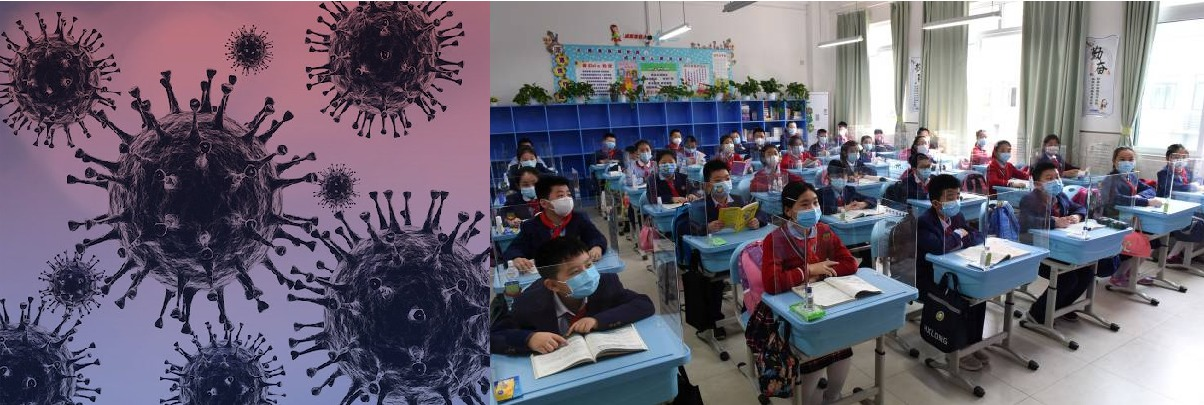

#### Historia
Hace unos meses durante tiempos de pandemia estuve trabajando como maestro de inglés en un colegio particular, para ese entonces la SEP informó que los alumnos de primaria podrian regresar a clases presenciales siempre y cuando se implementaran las medidas sanitarias necesarias, lo cual implico que llevamos largos e intensivos cursos de como lidiar con el regreso a clases. Entre las recomendaciones estaban: 
- Evitar aglomeraciones de alumnos
- Limpiar las butacas con desinfectante
- Pedirle a los niños que no se quitaran el cubre bocas y que se limpiaran las manos con gel constantemente 

pero sobre todo habia una regla importante: un número de alumnos por aula que permitia la SEP era 15, y se dejaba claro que éstos debían estar sentados a más de 1.5 metros de distancia entre unos con otros y al principio así fue, empecé con 11 alumnos la primera semana, la segunda semana llegaron 13, la tercera fueron 15 y la cuarta llegaron 16 y en las juntas de maestros me enteraba que mas alumnos se estaban inscribiendo. En este punto me pregunté ¿que al colegio le importa más lucrar que cumplir con las normas sanitarias? y al hablar con los demas maestros vi que opinaban igual que yo, la escuela estaba ignorando deliberadamente esa indicación. ¿o no?

#### Problema de la sana distancia 
Reflexionando un poco al respecto recorde un problema de optimización llamado **Los N hermanos hostiles** el cual conciste en acomodar $N$ hermanos en un cuarto lo más alejados posibles entre ellos para evitar que se peleen. Me dí cuenta que este problema se podia aplicar a la distribución de butacas en un salón de clase para maximizar la distancia entre parejas de butacas pero con una ligera modificación: mientras más hermanos (butacas) haya, menor será la distancia entre ellos, por lo que para unas dimensiones dadas del cuarto (salón de clases) habrá un número k para el cual la distancia entre butacas consecutivas sea menor que 1.5 metros y por lo tanto, la norma sanitaria se habrá violado.

El problema de la sana distancia entonces consiste en encontrar la distribución y el numero máximo de alumnos que podamos acomodar en un salon de clases de dimensiones $L_x$ y $L_y$ sin romper la regla que la distancia entre butacas consecutivas sea mayor de 1.5.

#### Formulación del modelo matemático

Sea k-1 el número máximo de alumnos que caben en un salón de clases de dimensiones $L_x \times L_y$ sin violar la norma sanitaria de los 1.5 metros y sea $r_{ij}$ la distancia entre el alumno $i$ y el alumno $j$. 

El modelo de optimización queda entonces:
$$
max\ r\\
sujeto\ a:\ (x_i-x_j)^2 + (y_i-y_j)^2 \geq 1.5
$$
donde:
$$
x\ \in \ [0,L_x]\ \ , \ \ y\ \in \ [0,L_y]
$$

Este problema se resolverá k veces en un loop hasta que se incumpla la norma de la sana distancia y se tomará el número k-1 como el máximo numero de alumnos permitidos para ese salón de clase específico.

#### Solución del problema
- Para resolver este problema se usara Pyomo que es un entorno de Python ampliamente usado para problemas de optimización.
- Los parametros de entrada son las dimensiones del aula $L_x=5$ metros, $L_y=6$ metros y un margen $m=1/2$ metro entre la butaca y la pared.
- El solver que usaremos para resolver el problema sera "ipopt" que es el que se utiliza para problemas de optimización no lineales.

In [198]:
# Importamos librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importamos el entorno pyomo
from pyomo.environ import *

Definimos el problema de optimización dentro de una función para optimizar los cálculos más eficientes.

Esta función tendrá 3 parametros:
- El número de alumnos
- El largo el aula
- El ancho del aula

In [199]:
def optimization(n,Dx,Dy):
    # Importamos la libreria random para el manejo de numero aleato
    import random
    
    # Creamos el modelo
    model = ConcreteModel()
    
    # Definimos los parametros
    model.N = Param(initialize=n) ; N = model.N # Numero de hermanos
    model.Lx = Param(initialize=Dx) ; Lx = model.Lx # Largo del aula
    model.Ly = Param(initialize=Dy) ; Ly = model.Ly # Ancho del aula
    
    # Definimos los sets para dar dimension a las variables
    model.i = RangeSet(1,N) 
    model.j = RangeSet(1,N) 
    
    # Creamos una función que genera valores aleatorios para inicializar las variables  
    def interval(model,i):                     # esto es necesario porque ayuda en la convergencia
        return random.uniform(0,1)             # de los problemas de optimizacion no lineales

    # Definimos las variables 
    model.x = Var( model.i , bounds=(0,Lx) , within=NonNegativeReals , initialize=interval ) ; x = model.x
    model.y = Var( model.i , bounds=(0,Ly) , within=NonNegativeReals , initialize=interval ) ; y = model.y
    model.r = Var(within=NonNegativeReals) ; r = model.r
    
    # Definimos la restriccion de la sana distancia | ri - rj | >= 1.5 metros
    def C1_rule(model,i,j):
        if i!=j:
            return (x[i]-x[j])**2 + (y[i]-y[j])**2 >= r**2
        else:
            return Constraint.Skip
    model.C = Constraint( model.i , model.j , rule=C1_rule )
    
    # Definimos la function objetivo
    model.z = Objective(expr = r , sense=maximize) 
    
    # Solucionamos el problema usando el solver "ipopt"
    opt = SolverFactory('ipopt')
    opt.solve(model)
    
    Xcord = np.array([ value(x[i]) for i in model.i ])
    Ycord = np.array([ value(y[i]) for i in model.i ])
    
    return value(model.z), Xcord, Ycord

Resolvemos el problema dentro de un ciclo For hasta que incumpla la norma de los 1.5 metros y registramos el valor de k

In [203]:
# Imponemos los valores de Lx y Ly:
margen=0.5 
Lx = 5.0 # ;  Lx = Lx - 2*margen 
Ly = 6.0 # ;  Ly = Ly - 2*margen

# Establecemos el valor de distancia maxima entre butacas:
Dmax = 1.5 

# Damos una semilla para la distancia > 1.5 para arancar el loop
distancia = 10

# como la i representa el numero de alumnos definimos el for desde 2 hasta un numero grande 
for i in range(2,100):
    distancia = optimization(i,Lx-2*margen,Ly-2*margen)[0]
    distancias.append(distancia)
    print('Entre',i,'alumnos la distancia es',distancia)
    
    if distancia <= Dmax:
        Nmax = i-1
        
    # usamos el comando "break" como condición de parada.
        break
print('--------------------------------------------------------------')
print('Para un salon de clases de dimensiones: (',Lx,'metros) x (',Ly,'metros)')
print('El numero de máximo de alumnos permitidos por aula es',Nmax)

Entre 2 alumnos la distancia es 6.403124301252447
Entre 3 alumnos la distancia es 4.716990602736306
Entre 4 alumnos la distancia es 4.029335851526557
Entre 5 alumnos la distancia es 2.9433895719837717
Entre 6 alumnos la distancia es 2.781249981594834
Entre 7 alumnos la distancia es 2.3599406159405456
Entre 8 alumnos la distancia es 2.2104970467317018
Entre 9 alumnos la distancia es 2.1314828555277123
Entre 10 alumnos la distancia es 1.8669167619260014
Entre 11 alumnos la distancia es 1.7917209009243769
Entre 12 alumnos la distancia es 1.6442688292998806
Entre 13 alumnos la distancia es 1.5978648798337418
Entre 14 alumnos la distancia es 1.5159934716958423
Entre 15 alumnos la distancia es 1.5092693912536572
Entre 16 alumnos la distancia es 1.4433118264679432
--------------------------------------------------------------
Para un salon de clases de dimensiones: ( 5.0 metros) x ( 6.0 metros)
El numero de máximo de alumnos permitidos por aula es 15


### Representación Gráfica

In [206]:
# Notemos que esta función tiene 3 argumentos, el primero es el numero de alumnos y los otros dos son las dimensiones del aula
def graphic(n,Dx,Dy):
    # Importamos la libreria random para el manejo de numero aleatorios
    import random
    # Creamos el modelo
    model = ConcreteModel()
    
    # Definimos los parametros
    model.N = Param(initialize=n) ; N = model.N # Numero de hermanos
    model.i = RangeSet(1,N) 
    model.j = RangeSet(1,N) 
    model.Lx = Param(initialize=Dx) ; Lx = model.Lx # Longitud de la arista en x
    model.Ly = Param(initialize=Dy) ; Ly = model.Ly # Longitud de la arista en y

    # Creamos una función que genera valores aleatorios para inicializar las variables  
    def interval(model,i):
        return random.uniform(0,1)
    # esto es necesario porque ayuda en la convergencia de los problemas de optimizacion no lineales
    
    rand = random.uniform(0,1)
    # Definimos las variables indexadas y en los intervalos [0,Lx] y [0,Ly] respectivamente
    model.x = Var( model.i , bounds=(0,Lx) , within=NonNegativeReals , initialize=interval )  
    x = model.x
    model.y = Var( model.i , bounds=(0,Ly) , within=NonNegativeReals , initialize=interval )  
    y = model.y
    model.r = Var(within=NonNegativeReals) ; r = model.r

    # Aplicamos la restriccion de la sana distancia | ri - rj | >= 1.5 metros
    def C1_rule(model,i,j):
        if i!=j:
            return (x[i]-x[j])**2 + (y[i]-y[j])**2 >= r**2
        else:
            return Constraint.Skip
        
    model.C = Constraint( model.i , model.j , rule=C1_rule )

    # Definimos la function objetivo
    model.z = Objective(expr = r , sense=maximize)

    # Solucionamos el problema usando el solver "ipopt"
    opt = SolverFactory('ipopt')
    opt.solve(model)

    Xcord = np.array([ value(x[i]) for i in model.i ])
    Ycord = np.array([ value(y[i]) for i in model.i ])
    
    plt.figure( figsize = (9,7.5))
    plt.scatter(Xcord,Ycord)
    plt.title('Distribución de alumnos - N='+str(Nmax))
    plt.xlim(-margen,Lx+margen)
    plt.ylim(-margen,Ly+margen)
    #plt.grid()
    plt.show()

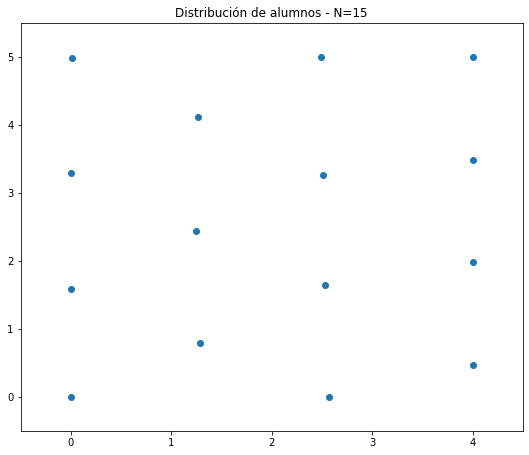

In [207]:
graphic(Nmax,Lx-2*margen,Ly-2*margen)

## Conclusión

El número maximo de alumnos permitidos en un salón de clases de dimensiones (5 metros) x (6 metros) respetando la restricción de $r_{ij}\geq 1.5$ metros obtenido en esta simulación es de 15. Suponiendo estas dimensiones para el salón en el que trabajaba y teniendo en cuenta que se presentaban 16 niños a clase concluimos que se rompió la regla.